# Parametric pendulum going chaotic

Warning: this is not Python, but Julia!

In [33]:
using OrdinaryDiffEq
import PyPlot; plt=PyPlot;

## Generic references

1. http://farside.ph.utexas.edu/teaching/329/lectures/node46.html
2. 10.1103/PhysRevLett.52.705 Suppression of Period Doubling in
   Symmetric Systems James W. Swift and Kurt Wiesenfeld
   Phys. Rev. Lett. 52, 705 – Published 27 February 1984
3. https://link.springer.com/article/10.1007/BF01013307
   McLaughlin, J.B. J Stat Phys (1981) 24: 375. https://doi.org/10.1007/BF01013307
   Period-doubling bifurcations and chaotic motion for a parametrically forced pendulum, 
4. https://content.sciendo.com/view/journals/ijame/20/2/article-p257.xml

## Defining the system

In [34]:
function parpend_eqn(du,u,p,t)
    γ, ω02, h = p
    y, θ = u
    du[1] = -γ*y-ω02*(1+h*cos(2*t))*sin(θ)
    du[2] = y
    nothing
end
function parpend_J(J, u, p, t)
    γ, ω02, h = p
    J[1,1] = -γ
    J[1,2] = -ω02*(1+h*cos(2*t))*cos(u[1])
    J[2,1] = 1
    J[2,2] = 0
    nothing
end
parpend = ODEFunction(parpend_eqn; jac=parpend_J)

(::ODEFunction{true,typeof(parpend_eqn),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,typeof(parpend_J),Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing}) (generic function with 7 methods)

## Doubling way to chaos

This one creates a Poincare cross-section for crossing the plane $\theta=0$, assuming $\theta$ is on the circle.

In [35]:
function poincaresec(u0, p, T, Ttr=0.0, alg=Tsit5();
                     save_everystep=false, save_start=false, save_end=false,
                     reltol=1e-10, abstol=1e-10, dtmax=0.1)
    stored_sinu2 = 1.0
    function poincaresec_cond(u, t, integrator)
        s = sin(u[2]/2)
        if t<Ttr && s!=0
            stored_sinu2 = s
            return 1.0
        else
            return stored_sinu2*s
        end
    end
    poincaresec_cb = ContinuousCallback(poincaresec_cond, int -> nothing,
                                        save_positions = (true, false))
    prob = ODEProblem(parpend, u0, Ttr+T, p)
    sol = solve(prob, alg, callback=poincaresec_cb,
                save_everystep=save_everystep,
                save_start=save_start, save_end=save_end,
                reltol=reltol, abstol=abstol, dtmax=dtmax)
    return sol
end

poincaresec (generic function with 3 methods)

Unexcited

In [36]:
function plot_evolutions(θ0set, dotθ0set, p, T;
        tlim=nothing, plotθ=false)
    fig, axis = plt.subplots(2,2)
    i = 1
    for ax in axis
        res = poincaresec([dotθ0set[i]; θ0set[i]], p, 0, T, save_everystep=true)
        ax.plot(res.t, map(x->x[1],res.u), label="dθ/dt", lw=1)
        if plotθ
            ax.plot(res.t, map(x->x[2],res.u), label="θ", lw=1)
        end
        if tlim!=nothing
            ax.set_xlim(tlim[1], tlim[2])
        end
        ax.set_ylim(-pi,pi)
        i += 1
    end
    axis[2,1].set_xlabel("t")
    axis[2,2].set_xlabel("t")
    plt.legend()
end

plot_evolutions (generic function with 1 method)

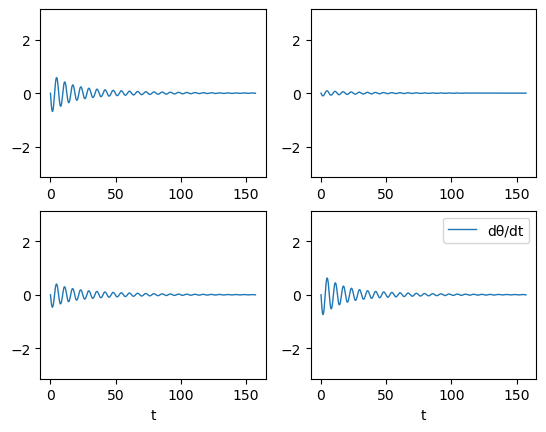

PyObject <matplotlib.legend.Legend object at 0x7fdbe84361f0>

In [37]:
plot_evolutions(rand(4), [0,0,0,0], [0.1, (1.0)^2, 0.1], 50pi)

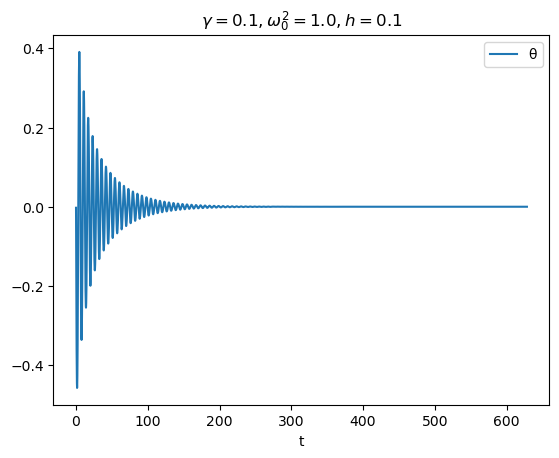

PyObject <matplotlib.legend.Legend object at 0x7fdbe0326f10>

In [38]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 0.1]
res=poincaresec(u0, p, 0π, 200pi, save_everystep=true)
plt.clf()
plt.plot(res.t,map(x->x[1],res.u), label="θ")
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
plt.xlabel("t")
plt.legend()

Swinging

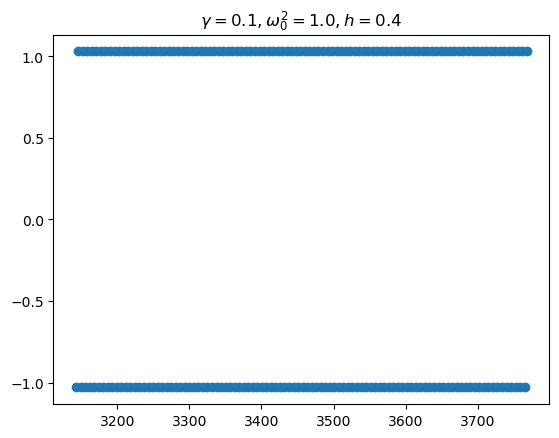

PyObject Text(0.5, 1.0, '$\\gamma=0.1, \\omega_0^2=1.0, h=0.4$')

In [39]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 0.4]
res=poincaresec(u0, p, 200π, 1000pi)
plt.clf()
plt.scatter(res.t,map(x->x[1],res.u))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plot(res.t,map(x->x[2],res.u))
#gcf()

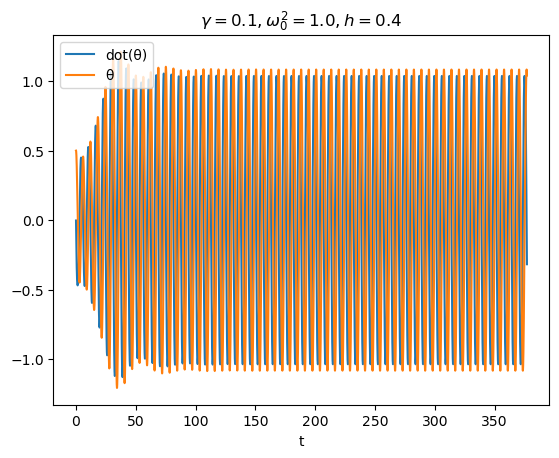

PyObject Text(0.5, 1.0, '$\\gamma=0.1, \\omega_0^2=1.0, h=0.4$')

In [40]:
res=poincaresec(u0, p, 20π, 100pi, save_everystep=true)
plt.clf()
fi=1
plt.plot(res.t[fi:end].-res.t[fi],map(x->x[1],res.u[fi:end]), label="dot(θ)")
plt.plot(res.t[fi:end].-res.t[fi],map(x->x[2],res.u[fi:end]), label="θ")
plt.xlabel("t"); plt.legend()
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#gcf()

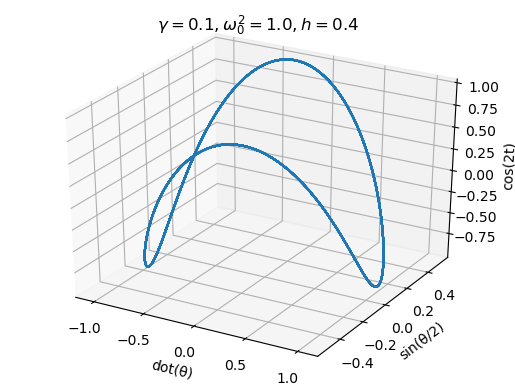

PyObject Text(0.5, 0.92, '$\\gamma=0.1, \\omega_0^2=1.0, h=0.4$')

In [41]:
res=poincaresec(u0, p, 20π, 100pi, save_everystep=true)
plt.clf()
fi=findfirst(res.t.>100pi)
plt.plot3D(map(x->x[1],res.u[fi:end]), map(x->sin(x[2]/2),res.u[fi:end]),
       cos.(2*res.t[fi:end]))
plt.xlabel("dot(θ)"); plt.ylabel("sin(θ/2)"); plt.zlabel("cos(2t)")
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#gcf()

Symmetry breaking -- note, that on top of symmetry breaking motion the period for velocity is halved $T=\pi$ (equal to driving frequency).

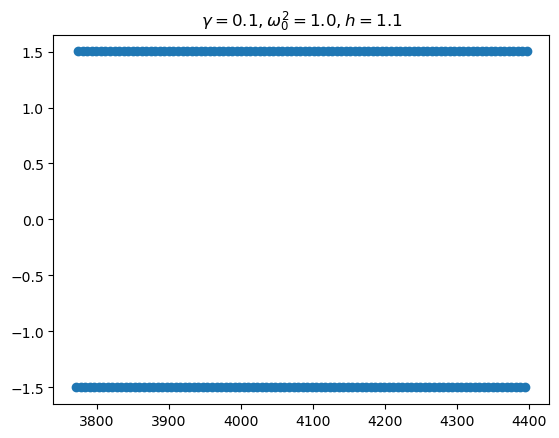

PyObject Text(0.5, 1.0, '$\\gamma=0.1, \\omega_0^2=1.0, h=1.1$')

In [42]:
u0 = [0; 0.1]
p = [0.1, (1.0)^2, 1.1]
res=poincaresec(u0, p, 200π, 1200pi)
plt.clf()
plt.scatter(res.t,map(x->x[1],res.u))
#plot(res.t,map(x->x[2],res.u))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")

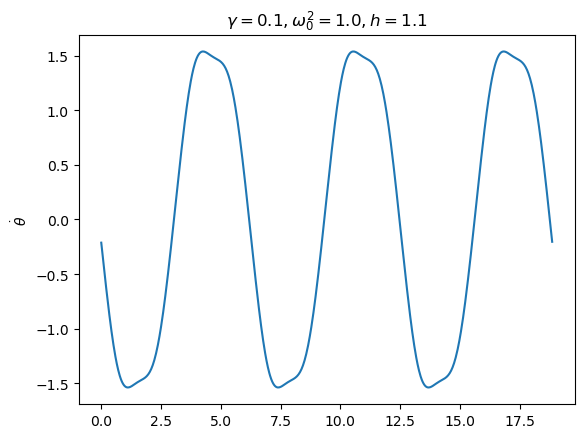

PyObject Text(29.689236111111114, 0.5, '$\\dot\\theta$')

In [43]:
res=poincaresec(u0, p, 6π, 1200pi, save_everystep=true)
plt.clf()
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
plt.plot(res.t[res.t.>1200pi].-1200pi,map(x->x[1],res.u[res.t.>1200pi]))
plt.ylabel("\$\\dot\\theta\$")
#plot(res.t[res.t.>1200pi].-1200pi,map(x->x[2],res.u[res.t.>1200pi]).+7000)

Period doubling

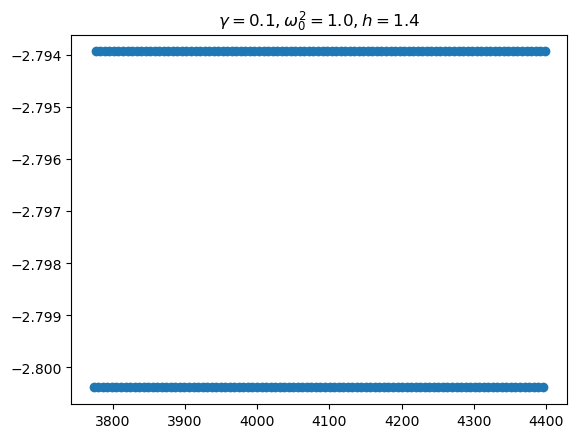

PyObject Text(0.5, 1.0, '$\\gamma=0.1, \\omega_0^2=1.0, h=1.4$')

In [44]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 1.4]
res=poincaresec(u0, p, 200π, 1200pi)
#plt.clf()
plt.scatter(res.t,map(x->x[1],res.u))
#plot(res.t,map(x->x[2],res.u))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plt.gcf()

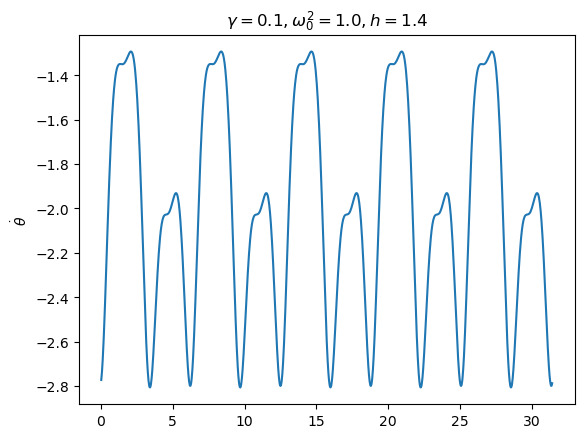

PyObject Text(29.689236111111114, 0.5, '$\\dot\\theta$')

In [45]:
res=poincaresec(u0, p, 10π, 1200pi, save_everystep=true)
#clf()
fi=findfirst(res.t.>1200pi)
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
plt.plot(res.t[fi:end].-1200pi,map(x->x[1],res.u[fi:end]))
plt.ylabel("\$\\dot\\theta\$")
#plot(res.t[fi:end].-1200pi,map(x->x[2],res.u[fi:end]).-res[2,fi])
#gcf()

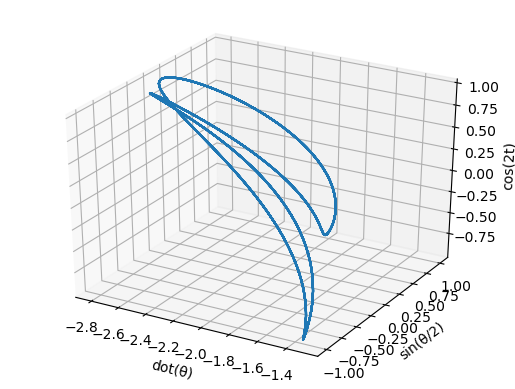

PyObject Text(0.09109821416582611, 0.01220484645882516, 'cos(2t)')

In [46]:
res=poincaresec(u0, p, 20π, 1200pi, save_everystep=true)
#clf()
fi=findfirst(res.t.>1200pi)
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
plt.plot3D(map(x->x[1],res.u[fi:end]), map(x->sin(x[2]/2),res.u[fi:end]),
       cos.(2*res.t[fi:end]))
plt.xlabel("dot(θ)"); plt.ylabel("sin(θ/2)"); plt.zlabel("cos(2t)")

Period 4

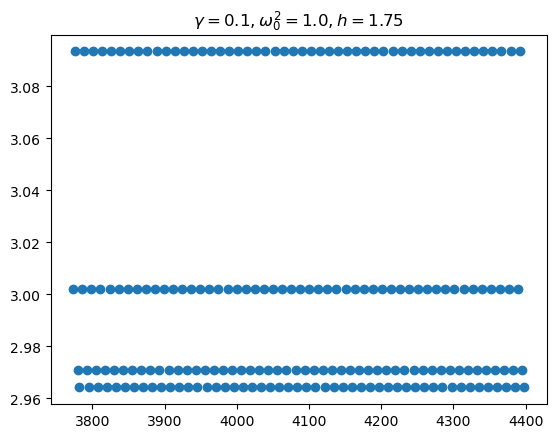

PyObject Text(0.5, 1.0, '$\\gamma=0.1, \\omega_0^2=1.0, h=1.75$')

In [47]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 1.75]
res=poincaresec(u0, p, 200π, 1200pi)
#clf()
plt.scatter(res.t,map(x->x[1],res.u))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plot(res.t,map(x->x[2],res.u))
#gcf()

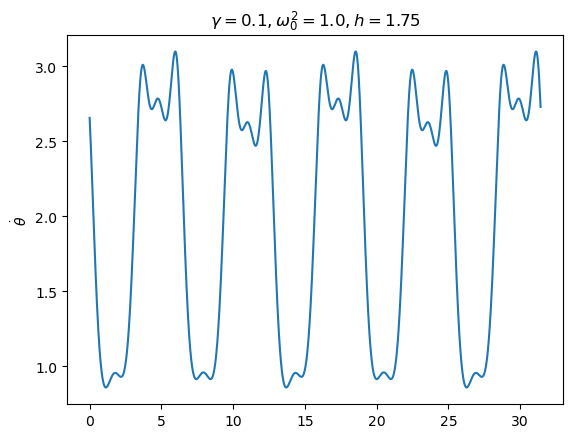

PyObject Text(29.68923611111112, 0.5, '$\\dot\\theta$')

In [48]:
res=poincaresec(u0, p, 10π, 1200pi, save_everystep=true)
#clf()
fi=findfirst(res.t.>1200pi)
#fi=1
plt.plot(res.t[fi:end].-1200pi,map(x->x[1],res.u[fi:end]))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
plt.ylabel("\$\\dot\\theta\$")
#plot(res.t[fi:end].-1200pi,map(x->x[2],res.u[fi:end]).-res[2,fi])
#gcf()

Period 8? May be integrator precision?

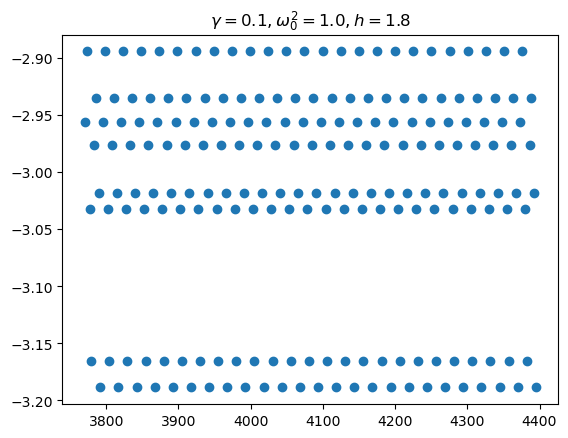

PyObject Text(0.5, 1.0, '$\\gamma=0.1, \\omega_0^2=1.0, h=1.8$')

In [49]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 1.8]
res=poincaresec(u0, p, 200π, 1200pi, Vern7(), reltol=1e-13, dtmax=0.01)
#clf()
plt.scatter(res.t,map(x->x[1],res.u))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plot(res.t,map(x->x[2],res.u))
#gcf()

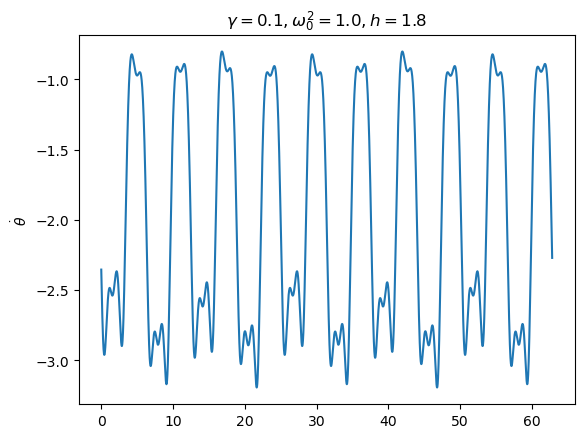

PyObject Text(29.689236111111114, 0.5, '$\\dot\\theta$')

In [50]:
res=poincaresec(u0, p, 20π, 1200pi, Vern7(), reltol=1e-13, dtmax=0.01, save_everystep=true)
#clf()
fi=findfirst(res.t.>1200pi)
plt.plot(res.t[fi:end].-1200pi,map(x->x[1],res.u[fi:end]))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
plt.ylabel("\$\\dot\\theta\$")
#plot(res.t[fi:end].-1200pi,map(x->x[2],res.u[fi:end]).-res[2,fi])
#gcf()

Chaos?

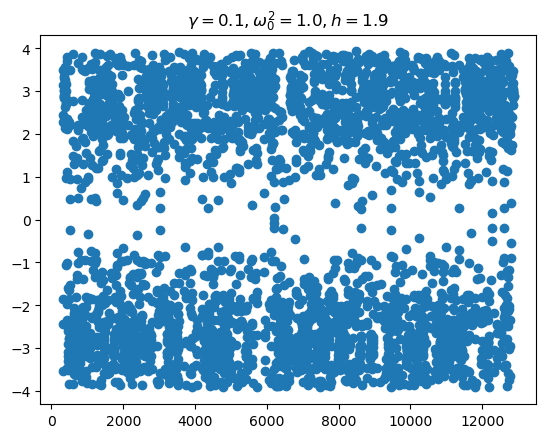

PyObject Text(0.5, 1.0, '$\\gamma=0.1, \\omega_0^2=1.0, h=1.9$')

In [51]:
u0 = [0; 0.5]
p = [0.1, (1.0)^2, 1.9]
res=poincaresec(u0, p, 4000π, 100pi)
#clf()
plt.scatter(res.t,map(x->x[1],res.u))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#plot(res.t,map(x->x[2],res.u))
#gcf()

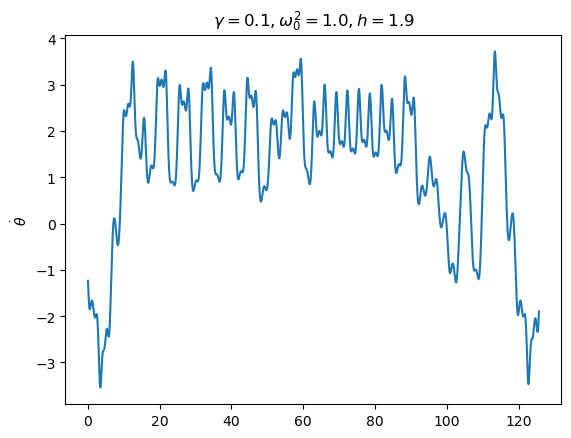

PyObject Text(29.68923611111112, 0.5, '$\\dot\\theta$')

In [52]:
res=poincaresec(u0, p, 40π, 100pi, save_everystep=true)
#plt.clf()
fi=findfirst(res.t.>100pi)
plt.plot(res.t[fi:end].-100pi,map(x->x[1],res.u[fi:end]))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
plt.ylabel("\$\\dot\\theta\$")
#plot(res.t[fi:end].-1200pi,map(x->x[2],res.u[fi:end]).-res[2,fi])
#gcf()

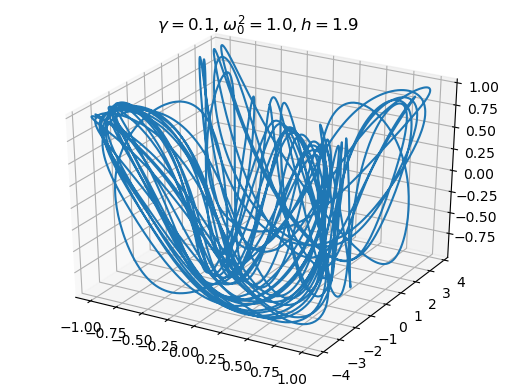

PyObject Text(0.5, 0.92, '$\\gamma=0.1, \\omega_0^2=1.0, h=1.9$')

In [53]:
res=poincaresec(u0, p, 50π, 230pi, save_everystep=true)
#clf()
fi=findfirst(res.t.>230pi)
plt.plot3D(map(x->cos(x[2]/2),res.u[fi:end]),
       map(x->x[1],res.u[fi:end]), 
    cos.(2*res.t[fi:end]))
plt.title("\$\\gamma=$(p[1]), \\omega_0^2=$(p[2]), h=$(p[3])\$")
#gcf()

## Kapitza's pendulum case


Upside down position $\theta=\pi$ is stable for $h^2>8/\omega_0^2/\omega^2$. See
https://en.wikipedia.org/wiki/Kapitza%27s_pendulum

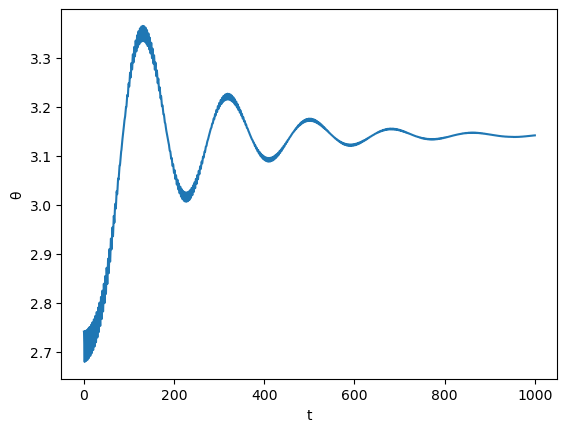

PyObject Text(0.5, 24.0, 't')

In [54]:
u0 = [0.0; π-0.4]
tspan = 1000.0
p = [0.01, (0.1)^2, 30.0]
prob = ODEProblem(parpend, u0, tspan, p)
sol = solve(prob, Tsit5(), reltol=1e-13, abstol=1e-13, dtmax=0.1*2*π)
#clf()
plt.plot(sol.t, map(x->x[2],sol.u))
plt.ylabel("θ"); plt.xlabel("t")
#gcf()